In [ ]:
# %% [code]
# !pip install -U tensorflow_datasets
# !apt install -y fonts-nanum fonts-nanum-coding

import sys
import os
import math

import numpy as np
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras

import pathlib

In [ ]:
TAKE = 10
BATCH = 32
EPOCH = 10
REPEATS = 5

STRING_CODEC = 'UTF-8'

IMG_HEIGHT = 224
IMG_WIDTH = 224
TEXT_LEN = 64
TOKEN_LEN = 16
LATENT = 256

FOLDER_BASE = '/kaggle/input/'
FOLDER = FOLDER_BASE+'naver-posts/'
FOLDER_IMG = FOLDER + 'img/'
FOLDER_SUMMARY = FOLDER + 'summary/'
FOLDER_TEXT = FOLDER + 'text/'
VOCAB_PATH = FOLDER + 'vocab'

FOLDER_W2T2V = FOLDER_BASE+'word2token2vec/'

TOKEN_SOS = '<SOS>'
TOKEN_EOS = '<EOS>'

# Any results you write to the current directory are saved as output.
print(tf.version.VERSION)

2.4.1


In [ ]:
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['roses', 'sunflowers', 'dandelion', 'tulips', 'daisy'],
      dtype='<U10')

In [ ]:
image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 3670 images belonging to 5 classes.


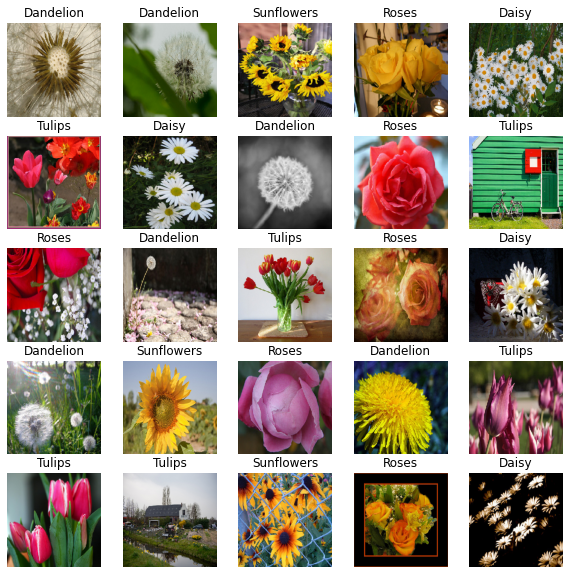

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5, 5, n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')
        
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [ ]:
def gen():
    yield from train_data_gen

ds = tf.data.Dataset.from_generator(gen, 
                                   (tf.float32, tf.int64),
                                   (tf.TensorShape([None, IMG_HEIGHT, IMG_WIDTH, 3]), tf.TensorShape([None, len(CLASS_NAMES)])))

for x in ds.take(1):
    print(x)

(<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.5137255 , 0.23137257, 0.3254902 ],
         [0.5176471 , 0.23529413, 0.32941177],
         [0.5176471 , 0.23529413, 0.32941177],
         ...,
         [0.7019608 , 0.43529415, 0.48627454],
         [0.69411767, 0.427451  , 0.48627454],
         [0.7019608 , 0.4156863 , 0.49411768]],

        [[0.5254902 , 0.24313727, 0.3372549 ],
         [0.5254902 , 0.24313727, 0.3372549 ],
         [0.5254902 , 0.24313727, 0.3372549 ],
         ...,
         [0.69411767, 0.42352945, 0.49411768],
         [0.69803923, 0.41960788, 0.4901961 ],
         [0.7058824 , 0.41960788, 0.49411768]],

        [[0.5294118 , 0.24705884, 0.34117648],
         [0.5294118 , 0.24705884, 0.34117648],
         [0.5294118 , 0.24705884, 0.34117648],
         ...,
         [0.6901961 , 0.41960788, 0.5019608 ],
         [0.69803923, 0.4156863 , 0.49411768],
         [0.70980394, 0.427451  , 0.48235297]],

        ...,

        [[0.57254905, 0.2509804 

In [ ]:
def model_img_encoder(img_input, latent_unit):
    def res_block(input_layer, filters, downsample=False, name=None):
        with tf.name_scope("res_block"):
            out = input_layer

            if downsample:
                out = keras.layers.Conv2D(filters, (3, 3), strides=(2, 2), name=name+"_downsample")(out)
                input_layer = out
                
            out = keras.layers.Conv2D(filters, (3, 3), padding='same')(out)
            out = keras.layers.BatchNormalization()(out)
            out = keras.layers.LeakyReLU(0.2)(out)

            out = keras.layers.Conv2D(filters, (3, 3), padding='same')(out)
            out = keras.layers.BatchNormalization()(out)

            out = out + input_layer
            out = keras.layers.LeakyReLU(0.2, name=name+"_out")(out)

            return out
    
    img = img_input
    
    img = keras.layers.Conv2D(64, (7, 7), strides=(2, 2))(img)
    img = keras.layers.BatchNormalization()(img)
    img = keras.layers.LeakyReLU(0.2)(img)
    img = keras.layers.MaxPool2D((3, 3), strides=(2, 2), name="pre")(img)
    
    img = res_block(img, 64, True, name="stg1-d")
    img = res_block(img, 64, name="stg1-"+str(i))
    
    img = res_block(img, 128, True, name="stg2-d")
    img = res_block(img, 128, name="stg2-"+str(i))

    img = res_block(img, 256, True, name="stg3-d")
    img = res_block(img, 256, name="stg3-"+str(i))
    
    img = res_block(img, 512, True, name="stg4-d")
    img = res_block(img, 512, name="stg4-"+str(i))
    
    img = keras.layers.AveragePooling2D(pool_size=(2, 2), padding='same')(img)
    img = keras.layers.Flatten()(img)
    img = keras.layers.Dense(latent_unit)(img)
    return keras.Model(inputs=[img_input], outputs=[img], name='image_latent')

In [ ]:
input_image = keras.Input((IMG_HEIGHT, IMG_WIDTH, 3), name='input_img')

model_infer = model_img_encoder(input_image, LATENT)
model_infer.summary()

Model: "image_latent"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 109, 109, 64) 9472        input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_109 (BatchN (None, 109, 109, 64) 256         conv2d_109[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_75 (LeakyReLU)      (None, 109, 109, 64) 0           batch_normalization_109[0][0]    
_______________________________________________________________________________________

In [ ]:
img_latent = model_infer(input_image)

classify = keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(img_latent)

model_train = keras.Model(inputs=[input_image], outputs=[classify])
model_train.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model_train.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 224, 224, 3)]     0         
_________________________________________________________________
image_latent (Functional)    (None, 256)               14280128  
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 14,281,413
Trainable params: 14,273,605
Non-trainable params: 7,808
_________________________________________________________________


In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('model_image2vec_train.h5', save_best_only=True)

VALID_TAKE = 3
ds_validation = ds.take(VALID_TAKE).cache()
    
m = model_train.fit(ds.skip(VALID_TAKE).prefetch(TAKE*2).take(TAKE),
          validation_data=ds_validation,
          epochs=40,
          callbacks=[checkpoint])

Epoch 1/40
10/10 [==============================] - 41s 4s/step - loss: 1.1754 - acc: 0.5031 - val_loss: 1.6376 - val_acc: 0.2500
Epoch 2/40
10/10 [==============================] - 40s 4s/step - loss: 1.1225 - acc: 0.5531 - val_loss: 2.0386 - val_acc: 0.3021
Epoch 3/40
10/10 [==============================] - 41s 4s/step - loss: 1.0668 - acc: 0.5906 - val_loss: 2.0115 - val_acc: 0.2188
Epoch 4/40
10/10 [==============================] - 41s 4s/step - loss: 1.1292 - acc: 0.5594 - val_loss: 2.4668 - val_acc: 0.2604
Epoch 5/40
10/10 [==============================] - 41s 4s/step - loss: 1.0322 - acc: 0.6000 - val_loss: 2.8286 - val_acc: 0.2604
Epoch 6/40
10/10 [==============================] - 41s 4s/step - loss: 0.9503 - acc: 0.6219 - val_loss: 1.6929 - val_acc: 0.2604
Epoch 7/40
10/10 [==============================] - 42s 4s/step - loss: 1.0494 - acc: 0.5750 - val_loss: 1.7651 - val_acc: 0.2604
Epoch 8/40
10/10 [==============================] - 41s 4s/step - loss: 0.9753 - acc: 0.63

In [ ]:
validation_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

In [ ]:
results = model_train.evaluate(validation_data_gen)

115/115 [==============================] - 62s 532ms/step - loss: 1.3310 - acc: 0.5640


In [ ]:
results

[1.3310307264328003, 0.5640326738357544]